In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

In [2]:
def preprocess_images(images, target_size=(300, 300)):
    preprocessed_images = []
    for img in images:
        if img.shape[:2] != target_size:
            img = cv.resize(img, target_size)
        if len(img.shape) == 2: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        if img.shape[2] == 4: 
            img = cv.cvtColor(img, cv.COLOR_BGRA2BGR)
        if img.shape[2] != 3: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        preprocessed_images.append(img)
    return np.array(preprocessed_images)


In [3]:
def display_sample(images, labels):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    
    for i, label in enumerate(unique_labels):
        idx = labels.index(label)
        img = images[idx]
        
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)
        
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def insertGambar(folder):
    data = []
    datalabel = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(label_folder)):
            img_path = os.path.join(label_folder, filename)
            if filename.endswith('.gif'):
                img = Image.open(img_path)
                img = np.array(img.convert('RGB'))
                img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            else:
                img = cv.imread(img_path)
            if img is not None:
                data.append(img)
                datalabel.append(label)
    return data, datalabel

In [5]:
def rotasi(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

In [6]:
def pencerminan(image, axis):
    return cv.flip(image, axis)

In [7]:
def augmentasi(data, labels, banyakData):
    augmented_data = []
    augmented_labels = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        for j in range(banyakData):
            if j % 2 == 0:
                rotated_90 = rotasi(data[i], 90)
                augmented_data.append(rotated_90)
                augmented_labels.append(labels[i])
            elif j % 2 == 1:
                rotated_minus_90 = rotasi(data[i], -90)
                augmented_data.append(rotated_minus_90)
                augmented_labels.append(labels[i])
            elif j % 4 == 2:
                flipped_axis_0 = pencerminan(data[i], 0)
                augmented_data.append(flipped_axis_0)
                augmented_labels.append(labels[i])
            elif j % 4 == 3:
                flipped_axis_1 = pencerminan(data[i], 1)
                augmented_data.append(flipped_axis_1)
                augmented_labels.append(labels[i])
    return augmented_data, augmented_labels

In [8]:
data, label = insertGambar("Sea Animal")
print("Data: ", len(data))
print("Label: ", len(label))

100%|██████████| 200/200 [00:00<00:00, 278.33it/s]


Data:  1150
Label:  1150


In [9]:
dataResize = preprocess_images(data, target_size=(300, 300))
augmented_data, augmented_labels = augmentasi(dataResize, label, banyakData=4)
print("Jumlah total dataset setelah augmentasi:", len(augmented_data))

100%|██████████| 1150/1150 [00:11<00:00, 97.99it/s]

Jumlah total dataset setelah augmentasi: 5750


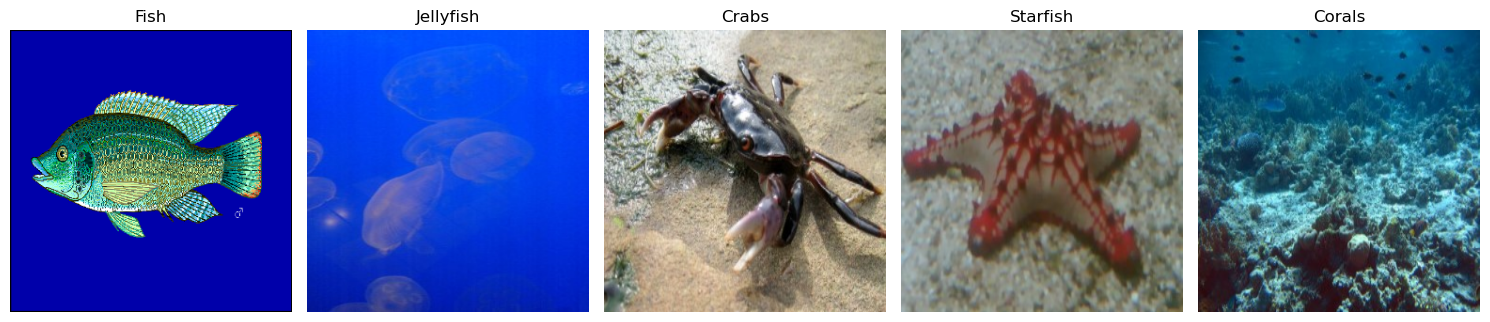

In [10]:
display_sample(augmented_data, augmented_labels)

In [11]:
def median_blur(images, ksize=5):
    blurred_images = []
    for img in images:
        blurred_img = cv.medianBlur(img, ksize)
        blurred_images.append(blurred_img)
    return np.array(blurred_images)

def gaussian_blur(images, ksize=5, sigma=0):
    blurred_images = []
    for img in images:
        blurred_img = cv.GaussianBlur(img, (ksize, ksize), sigma)
        blurred_images.append(blurred_img)
    return np.array(blurred_images)

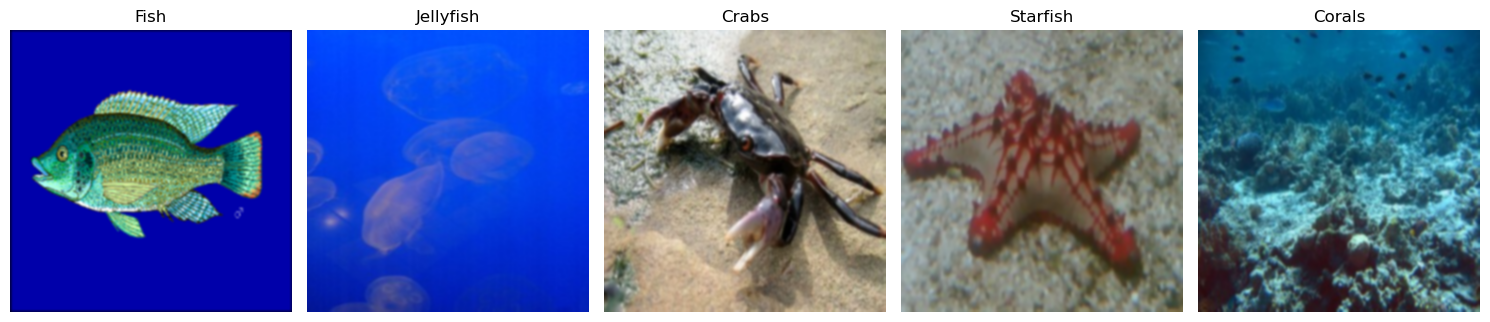

In [12]:
dataReduce = gaussian_blur(augmented_data)
display_sample(dataReduce, augmented_labels)

In [13]:
def grayscale(data):
    dataGray = []
    for img in data:
        if len(img.shape) == 3:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray = img
        dataGray.append(gray)
    return dataGray

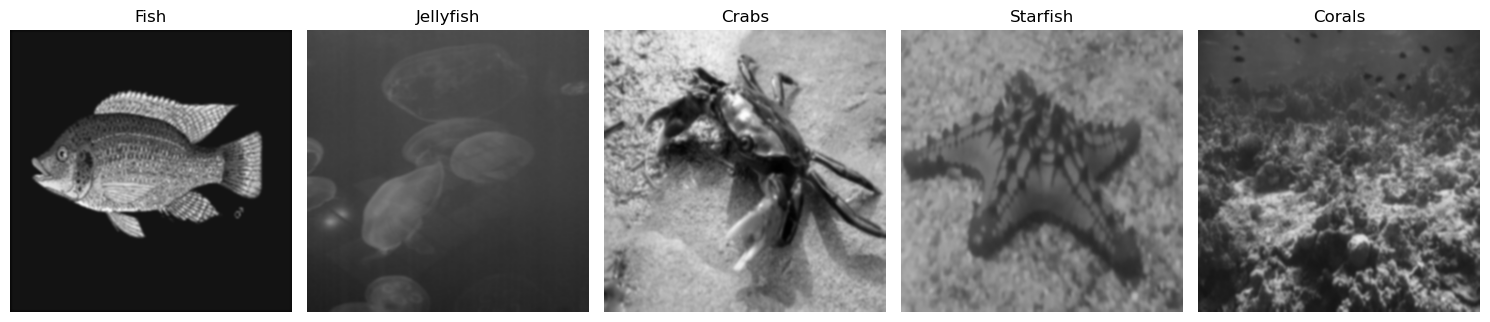

In [14]:
dataGray = grayscale(dataReduce)
display_sample(dataGray, augmented_labels)

In [15]:
def normalize_images(data):
    normalized_data = []
    for img in data:
        img = img / 255.0
        normalized_data.append(img)
    return np.array(normalized_data)

def batch_normalize(images, batch_size):
    normalized_batches = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        normalized_batch = normalize_images(batch)
        normalized_batches.extend(normalized_batch)
    return np.array(normalized_batches)

In [16]:
X_cnn = batch_normalize(dataGray, batch_size=128)
X_cnn = np.expand_dims(X_cnn, axis=-1)

encoder = LabelEncoder()
y_cnn_encoded = encoder.fit_transform(augmented_labels)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn_encoded, test_size=0.2, random_state=42)

print("Training data shape:", X_cnn_train.shape)
print("Testing data shape:", X_cnn_test.shape)

Training data shape: (4600, 300, 300, 1)
Testing data shape: (1150, 300, 300, 1)


In [17]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

In [18]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax') 
])

c:\Users\harma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [20]:
cnn_history = cnn_model.fit(
    X_cnn_train, y_cnn_train,
    validation_data=(X_cnn_test, y_cnn_test),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.3953 - loss: 1.4674 - val_accuracy: 0.5904 - val_loss: 0.9986
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - accuracy: 0.6158 - loss: 0.9724 - val_accuracy: 0.6904 - val_loss: 0.8173
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.7198 - loss: 0.7442 - val_accuracy: 0.7774 - val_loss: 0.6354
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.8228 - loss: 0.4943 - val_accuracy: 0.8191 - val_loss: 0.5876
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.8644 - loss: 0.3623 - val_accuracy: 0.8496 - val_loss: 0.5416
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.9306 - loss: 0.2230 - val_accuracy: 0.8835 - val_loss: 0.5012
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.9471 - loss: 0.1630 - val_accuracy: 0.8965 - val_loss: 0.5085
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.9525 - loss: 0.1421 - val_accu

In [21]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_cnn_test, y_cnn_test)
y_cnn_pred = cnn_model.predict(X_cnn_test)
y_cnn_pred_classes = np.argmax(y_cnn_pred, axis=1)

print("Accuracy CNN:", cnn_accuracy)
print(classification_report(y_cnn_test, y_cnn_pred_classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 531ms/step - accuracy: 0.9162 - loss: 0.4197
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step
Accuracy CNN: 0.9052174091339111
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       214
           1       0.94      0.89      0.92       247
           2       0.93      0.87      0.90       199
           3       0.92      0.95      0.93       298
           4       0.90      0.86      0.88       192

    accuracy                           0.91      1150
   macro avg       0.91      0.90      0.90      1150
weighted avg       0.91      0.91      0.91      1150



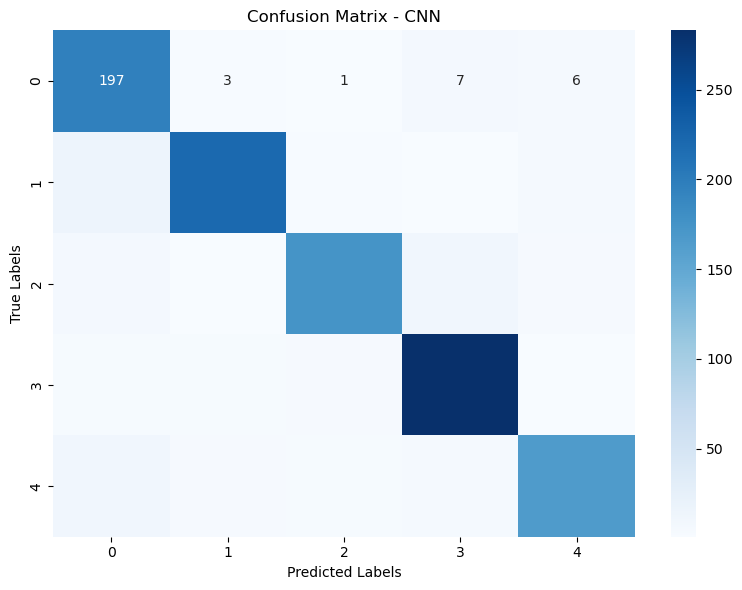

In [34]:
conf_matrix_cnn = confusion_matrix(y_cnn_test, y_cnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.tight_layout() 
plt.show()

In [33]:
print(conf_matrix_cnn)


[[197   3   1   7   6]
 [ 16 221   3   1   6]
 [  7   2 174  11   5]
 [  4   4   5 283   2]
 [ 11   5   4   6 166]]


In [31]:
# Invers transform dari encoded label ke label kategori
y_true_labels = encoder.inverse_transform(y_cnn_test)
y_pred_labels = encoder.inverse_transform(y_cnn_pred_classes)

print("True Labels vs Predicted Labels:")
for i in range(len(y_true_labels)):
    print(f"True Label: {y_true_labels[i]}, Predicted Label: {y_pred_labels[i]}")


True Labels vs Predicted Labels:
True Label: Fish, Predicted Label: Fish
True Label: Starfish, Predicted Label: Starfish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Fish, Predicted Label: Fish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Crabs, Predicted Label: Corals
True Label: Crabs, Predicted Label: Crabs
True Label: Corals, Predicted Label: Corals
True Label: Corals, Predicted Label: Corals
True Label: Crabs, Predicted Label: Starfish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Fish, Predicted Label: Fish
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Corals, Predicted Label: Corals
True Label: Crabs, Predicted Label: Corals
True Label: Jellyfish, Predicted Label: Jellyfish
True Label: Corals, Predicted Label: Corals
True Label: Jellyfish, Predicted Label: Jellyfish


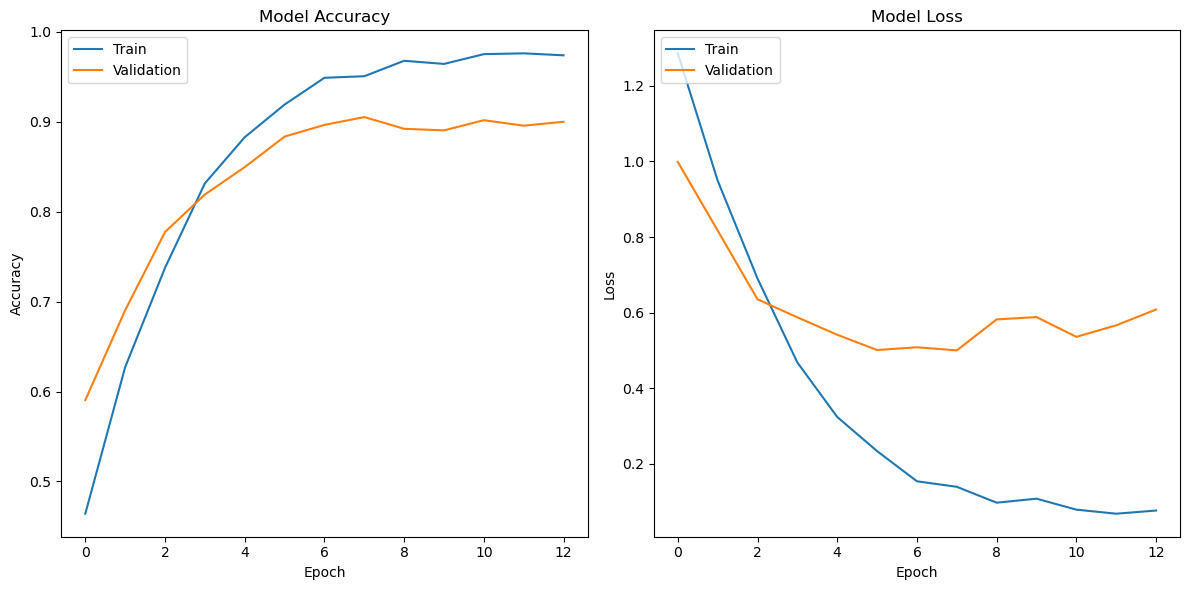

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()